In [17]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Fetch data
url = "http://127.0.0.1:8000/api/v1/data/?table_name=precios_materiales&limit=1000"
try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    print(f"✓ Successfully fetched {len(data['data'])} records")
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    raise
# Convert to Data Frame
df = pd.DataFrame(data['data'])

#Convert date to date of Dataframe
df['date'] = pd.to_datetime(df['date'])

#Variable a analizar 
var_analizar = 'varilla_distribuidor'

df.head()




✓ Successfully fetched 190 records


,id,date,year,scrap,gas,rebar,hrcc1,scrap_mxn,gas_mxn,rebar_mxn,hrcc1_mxn,tipo_de_cambio,varilla_distribuidor,varilla_credito,precio_mercado
0,272,2022-01-02,2022,467.5,3.92,715.0,1415.0,9518.300,79.8112,14557.400,28809.40,20.36,20038.525,20447.477,20647.477
1,271,2022-01-09,2022,467.5,4.26,700.0,1437.0,9485.575,86.4354,14203.000,29156.73,20.29,19969.630,20377.176,20577.176
2,270,2022-01-16,2022,474.0,4.00,703.5,1425.0,9693.300,81.8000,14386.575,29141.25,20.45,20406.947,20823.416,21023.416
3,269,2022-01-23,2022,470.0,4.64,702.0,1170.0,9771.300,96.4656,14594.580,24324.30,20.79,20571.158,20990.977,21190.977
4,268,2022-01-30,2022,502.5,4.57,737.0,1190.0,10381.650,94.4162,15226.420,24585.40,20.66,21856.105,22302.148,22502.148


En este ejemplo analizare la serie de tiempo del precio de la varilla del distribuidor


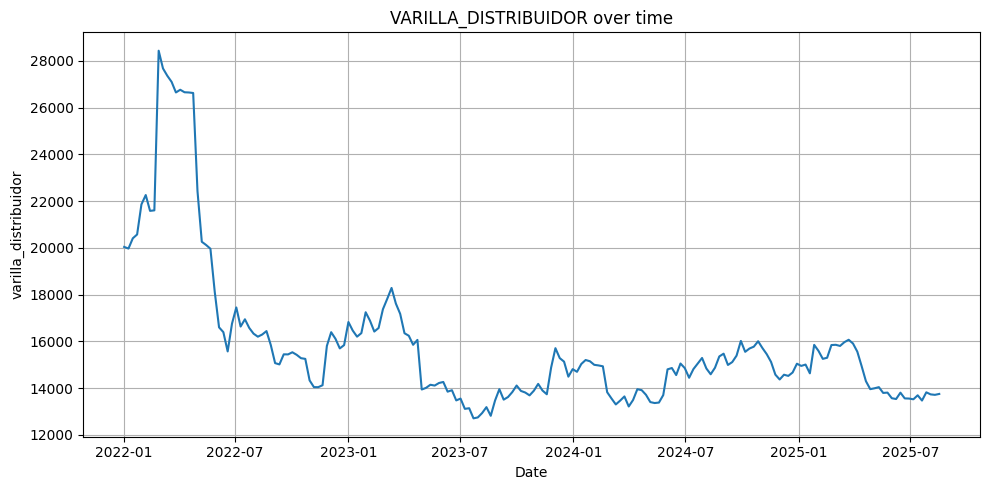

In [6]:
serie = df[var_analizar]

# Plot with date on x-axis
plt.figure(figsize=(10, 5))
plt.plot(df['date'], serie,linestyle='-')
plt.title(f"{var_analizar.upper()} over time")
plt.xlabel("Date")
plt.ylabel(var_analizar)
plt.grid(True)
plt.tight_layout()
plt.show()



In [19]:
import yfinance as yf

#download vix data
vix = yf.download("^VIX", start="2022-01-01", end="2025-01-07")


# 2. Reset index to get date as a column
vix = vix.reset_index()

# 3. Keep only the date and the Close price, rename column
vix = vix[['Date', 'Close']].rename(columns={'Date': 'date', 'Close': 'VIX'})

# 4. Make sure date column is datetime
vix['date'] = pd.to_datetime(vix['date'])

vix.head()


/var/folders/85/n4g_j3s15b137c5r7cyc_z200000gn/T/ipykernel_17771/1712130543.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start="2022-01-01", end="2025-01-07")
[*********************100%***********************]  1 of 1 completed


Price,date,VIX
Ticker,,^VIX
0,2022-01-03,16.600000
1,2022-01-04,16.910000
2,2022-01-05,19.730000
3,2022-01-06,19.610001
4,2022-01-07,18.760000


In [20]:
merged = pd.merge_asof(
    df.sort_values("date"),
    vix.sort_values("date"),
    on="date",
    direction="backward"
)

MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

Paso 1: Verificar estacionariedad

In [53]:
from statsmodels.tsa.stattools import adfuller
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [54]:

check_stationarity(serie)




ADF Statistic: -4.420651
p-value: 0.000273
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
Stationary


Como el p-value es menor a 0.05 la serie es estacionaria y puedo utilizar AR o MA 

Esto de interpreta que al hacer este analisis estadistico muestra la serie estable en el tiempo, no presenta tendencias aleatorias, y sus variaciones son predecibles dentro de un rango constante

Paso 2: Revisar ACF y PACF
Esto nos dira que modelo conviene

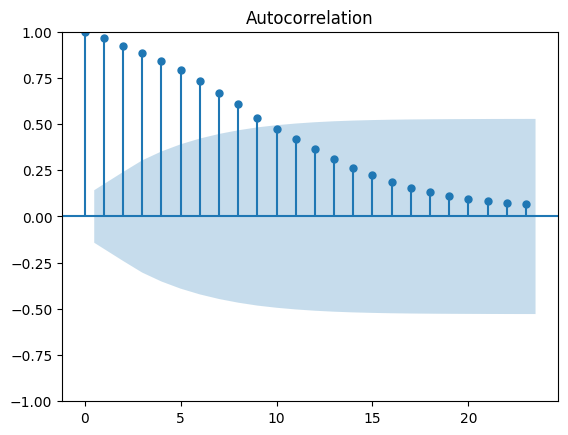

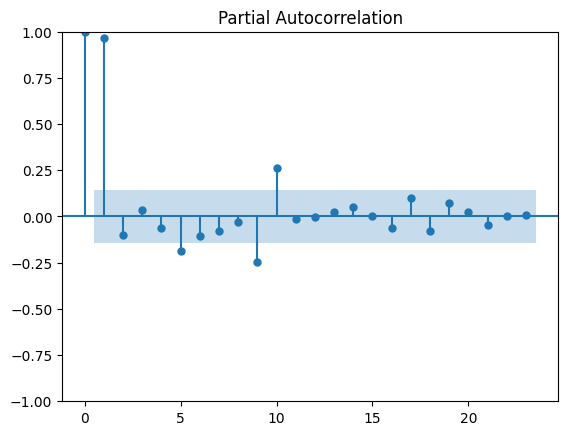

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(serie)
plot_pacf(serie)
plt.show()

Al analizar ACF, se ve que decae lentamente, eso quiere decir que hay una tendencia, y se sugiere AR


En PACF veo un pico en el lag 1, y ahi corte la serie seguido lo de ahi oscila en la banda de confianza
Lo que se sugiere un AR(1)

In [56]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

train_serie, test_serie = train_test_split(serie, test_size=0.2, shuffle=False)

#Opcion si quiero hacer manual el train _ test
#split_index = int(len(df) * 0.8)
#train = df.iloc[:split_index]
#test = df.iloc[split_index:]

#Autoregresivo orden 1
modelo = ARIMA(train_serie, order=(1, 0,0))
fitted = modelo.fit()


#print(fitted.summary())
pred = fitted.forecast(steps=len(test_serie))



#Autoregresivo orden 1
modelo_ma = ARIMA(train_serie, order=(0, 0,1))
resultado_ma = modelo.fit()

print(resultado_ma.summary())


                                SARIMAX Results                                 
Dep. Variable:     varilla_distribuidor   No. Observations:                  152
Model:                   ARIMA(1, 0, 0)   Log Likelihood               -1240.540
Date:                  Sun, 26 Oct 2025   AIC                           2487.080
Time:                          20:59:52   BIC                           2496.151
Sample:                               0   HQIC                          2490.765
                                  - 152                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.619e+04   2272.655      7.123      0.000    1.17e+04    2.06e+04
ar.L1          0.9675      0.016     61.096      0.000       0.936       0.999
sigma2       7.04e+05   2.17e+04    

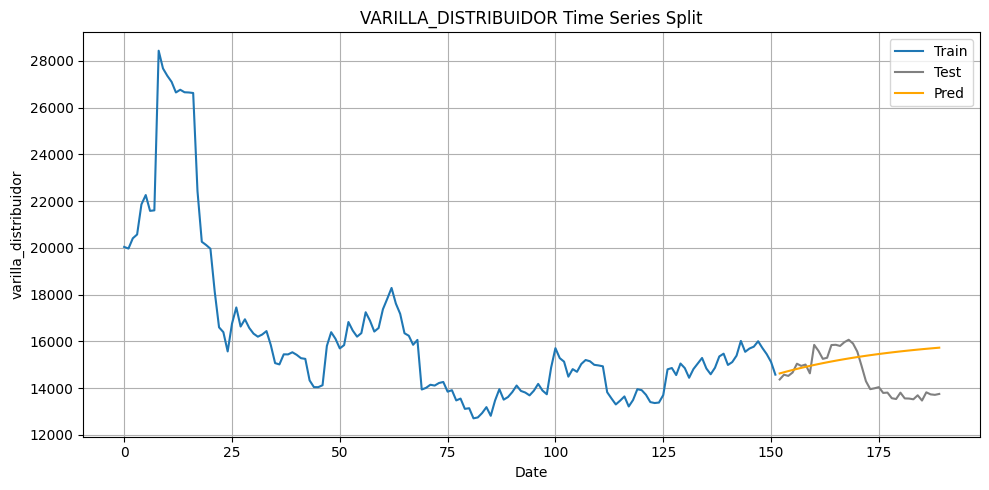

In [57]:

# Plot with date on x-axis
plt.figure(figsize=(10, 5))
plt.plot(train_serie.index, train_serie, label="Train")
plt.plot(test_serie.index, test_serie, label="Test", color="gray")

# Plot predictions
plt.plot(test_serie.index, pred, label="Pred", color="orange")

plt.legend()
plt.title(f"{var_analizar.upper()} Time Series Split")
plt.xlabel("Date")
plt.ylabel(var_analizar)
plt.grid(True)
plt.tight_layout()
plt.show()
